In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches

from src.utils.video_utils import get_video, get_frame_from_video
from src.utils.cloud_utils import get_mask as get_cloud_mask
from src.utils.cloud_utils import get_model_from as get_cloud_model_from
from src.utils.ground_utils import get_mask as get_ground_mask
from src.utils.ground_utils import get_model_from as get_ground_model_from

DATA_PATH = '../data/'
GENERATED_PATH = '../generated/'
LDR_PATH = f'{DATA_PATH}ldr/'
GENERATED_MASK_PATH = f'{GENERATED_PATH}sky_cloud_segmentation/scene_masks/'

In [3]:
ground_model_type = 'deeplabv3mobilenetv3large'
ground_model_save_path = f"{DATA_PATH}sky_ground_segmentation/models/{ground_model_type}_ranger_pretrained.pth"
ground_model = get_ground_model_from(model_save_path=ground_model_save_path, model_type=ground_model_type)

✅ Loaded pretrained model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


In [4]:
cloud_model_save_path = f"{DATA_PATH}sky_cloud_segmentation/models/deeplabv3resnet101_ranger_pretrained.pth"
cloud_model = get_cloud_model_from(model_save_path=cloud_model_save_path)

✅ Loaded pretrained model deeplabv3resnet101 with 60,991,576 learnable parameters.
✅ Loaded model from ../data/sky_cloud_segmentation/models/deeplabv3resnet101_ranger_pretrained.pth


In [12]:
def plot_scene_segmentation(part_number = 1, scene_number = 1):
    scene_path = f'{LDR_PATH}processed/P{part_number}Scene{scene_number:02d}.mp4'
    scene_video = get_video(scene_path)
    scene_frame, _ = get_frame_from_video(scene_video, 3, split=False, masked=True, reframed=True)

    # Get ground mask
    scene_frame = cv2.cvtColor(scene_frame, cv2.COLOR_BGR2RGB) / 255.0
    scene_ground_mask = get_ground_mask(scene_frame, ground_model)
    scene_frame = scene_frame * scene_ground_mask[:, :, np.newaxis]

    # Get ground mask
    scene_ground_mask = get_cloud_mask(scene_frame, cloud_model, factor=0.5)

    # Plot
    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(1, 2)

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.imshow(scene_frame)
    ax0.set_title('Original image')
    ax0.axis('off')

    # Get colored mask differences
    red_mask = scene_frame.copy()
    red_mask[scene_ground_mask == 2] = [1, 0, 0]
    red_mask[scene_ground_mask == 1] = [0, 0.7, 0.7]
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.imshow(red_mask)
    ax1.set_title('Segmentation Mask')
    ax1.axis('off')

    plt.suptitle(f'Ground segmentation for Scene {scene_number:02d}')

    # Add legend for misclassification
    legend_patches = [
        mpatches.Patch(color='black', label='Ground'),
        mpatches.Patch(color='red', label='Cloud'),
        mpatches.Patch(color='darkcyan', label='Sky')
    ]
    plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    # Save plot
    scene_plot_save_path = f'{GENERATED_MASK_PATH}cloud_segmentation_part{part_number}_scene{scene_number:02d}_mask.png'
    plt.savefig(scene_plot_save_path, bbox_inches='tight')
    print(f'💾 Saved plot for scene {scene_number} at {scene_plot_save_path}')

    plt.tight_layout()
    plt.show()

💾 Saved plot for scene 10 at ../generated/sky_cloud_segmentation/scene_masks/cloud_segmentation_part1_scene10_mask.png


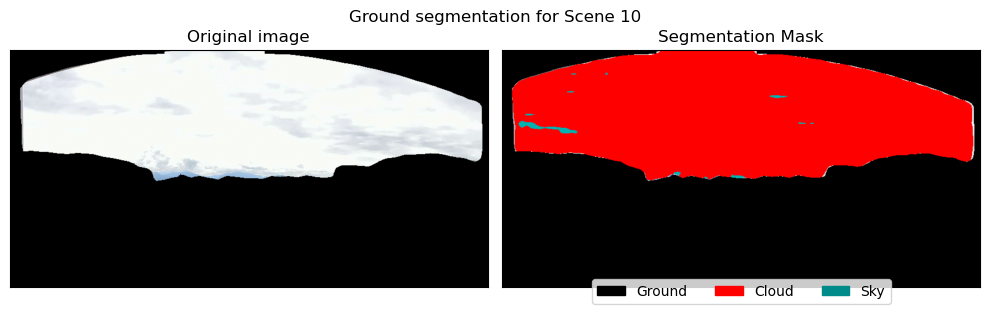

In [22]:
plot_scene_segmentation(1, 10)